In [1]:
%matplotlib inline


Training a Classifier
=====================



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].
<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [3]:
# Set up dataset and classes

transform = transforms.Compose(
    [transforms.Resize((400,400), interpolation=Image.NEAREST), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_dir = '../cub_birds_data/'

dataSet = torchvision.datasets.ImageFolder(root=data_dir+'images', transform=transform)

num_train = int(len(dataSet) * .8)
num_val = len(dataSet) - num_train

trainSet, valSet = torch.utils.data.random_split(dataSet, [int(num_train), int(num_val)])

trainloader = torch.utils.data.DataLoader(dataSet, batch_size=8,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valSet, batch_size=8,
                                          shuffle=True, num_workers=2)

f = open(data_dir + "lists/classes.txt", "r")
classes = []
for x in f:
  classes.append(x[4:-1]) 

In [4]:
print(type(dataSet))
print(type(trainSet))
print(type(trainloader))

<class 'torchvision.datasets.folder.ImageFolder'>
<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataloader.DataLoader'>


### Let us show some of the training images, for fun.



In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


class1: 1   Laysan_Albatross


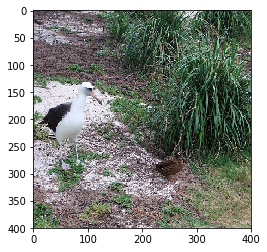

In [6]:
# Show example image with label

im1, class1 = dataSet[39]
print('class1:', class1, ' ', classes[class1])
imshow(im1)

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [7]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# use resnet18 network and change the last layer to output 200 numbers
# for our 200 classes

net = models.resnet18()
#net.fc = torch.nn.Linear(512, 200)
net.fc = torch.nn.Linear(512, 10) # trying smaller dataset
net = nn.Sequential(
    net,
    nn.Softmax(1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache() # for emptying out CUDA cache
print('Cuda device:', device)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Cuda device: cuda:0


### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [8]:
# same uncertainty measure as seen in that medium post
# uncertainty = most confident - least confident
# we want to put the smallest uncertainties in our training
# because that means that that sample is not well defined

def get_active_batches(trainloader, net, num_batches=1, print_f=False): 
    flag = True
    #data_active = None
    #labels_active = None
    #uncertain_ratio = None
    act_dict = {}
    count_key = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = [d.to(device) for d in data]

        outputs = net(inputs)
        
        outputs_cpu = outputs.cpu()
        outputs_np = outputs_cpu.detach().numpy()
        
        max_batch = 0
        min_batch = 0
        for out in outputs_np:
            max_batch += max(out)
            min_batch += min(out)
        
        if len(act_dict.keys()) < num_batches:
            act_dict[count_key] = [max_batch - min_batch, inputs, labels]
            count_key += 1
        else:
            for key in act_dict:
                if act_dict[key][0] > max_batch - min_batch:
                    act_dict[key] = [max_batch - min_batch, inputs, labels]
    
    if print_f:
        print('largest uncertainties', [act_dict[key][0] for key in act_dict])
    active_data = []
    active_labels = []
    for key in act_dict:
        active_data.append(act_dict[key][1])
        active_labels.append(act_dict[key][2])
    
    return active_data, active_labels

def train(net, inputs, labels, print_f=False):
    assert len(inputs) == len(labels)
    for i in range(len(inputs)):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs[i])
        loss = criterion(outputs, labels[i])
        loss.backward()
        optimizer.step()
        if print_f:
            print('loss:', loss.item())
        return loss.item()
    
loss = 1
training_epochs = 2
num_epoch = 0
losses = []
while loss > 0.2 and num_epoch < 150:
    print_f = False
    if num_epoch % 10 == 0:
        print('Num_epoch: ', num_epoch)
        print_f = True
    data_act, labels_act = get_active_batches(trainloader, net, 5, print_f)
    loss = train(net, data_act, labels_act, print_f)
    losses.append(loss)
    num_epoch += 1
    

print('Finished Training')

Num_epoch:  0
largest uncertainties [0.13105806335806847, 0.13105806335806847, 0.13105806335806847, 0.13105806335806847, 0.13105806335806847]
loss: 2.327220916748047
Num_epoch:  10
largest uncertainties [0.1719612292945385, 0.1719612292945385, 0.1719612292945385, 0.1719612292945385, 0.1719612292945385]
loss: 2.176020383834839
Num_epoch:  20
largest uncertainties [0.9539314766880125, 0.9539314766880125, 0.9539314766880125, 0.9539314766880125, 0.9539314766880125]
loss: 1.4976329803466797
Num_epoch:  30
largest uncertainties [0.9975415982044069, 0.9975415982044069, 0.9975415982044069, 0.9975415982044069, 0.9975415982044069]
loss: 1.46307373046875
Num_epoch:  40
largest uncertainties [0.9991581036738353, 0.9991581036738353, 0.9991581036738353, 0.9991581036738353, 0.9991581036738353]
loss: 2.460946798324585
Num_epoch:  50
largest uncertainties [0.9991766169769107, 0.9991766169769107, 0.9991766169769107, 0.9991766169769107, 0.9991766169769107]
loss: 1.461787462234497
Num_epoch:  60
largest u

In [9]:
def default_training(net, trainloader, num_epochs):
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            #inputs, labels = data.to(device)
            inputs, labels = [d.to(device) for d in data]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0


Let's quickly save our trained model:



In [10]:
PATH = './cub_birds_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data


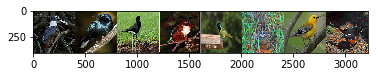

GroundTruth:  Red_winged_Blackbird Red_winged_Blackbird Brewer_Blackbird Red_winged_Blackbird Red_winged_Blackbird Red_winged_Blackbird Red_winged_Blackbird Red_winged_Blackbird


In [11]:
# Show example images

dataiter = iter(valloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(valloader.batch_size)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [12]:
#net = Net()
#net = models.resnet18()
#net.load_state_dict(torch.load(PATH))

Okay, now let us see what the neural network thinks these examples above are:



In [13]:
# Example outputs

outputs = net(images.to(device))
outputs.shape

print('Ground Truth Labels:')
[print(classes[label]) for label in labels]
print('\nOutput Labels:')
[print(classes[list(out).index(max(out))]) for out in outputs]

images_gpu = images.to(device)
net(images_gpu).shape

Ground Truth Labels:
Red_winged_Blackbird
Red_winged_Blackbird
Brewer_Blackbird
Red_winged_Blackbird
Red_winged_Blackbird
Red_winged_Blackbird
Red_winged_Blackbird
Red_winged_Blackbird

Output Labels:
Red_winged_Blackbird
Red_winged_Blackbird
Red_winged_Blackbird
Red_winged_Blackbird
Red_winged_Blackbird
Red_winged_Blackbird
Red_winged_Blackbird
Red_winged_Blackbird


torch.Size([8, 10])

### Outputs
The outputs are energies for the 200 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy. 
Let us look at how the network performs on the whole dataset.



In [14]:
correct = 0
total = 0
with torch.no_grad():
    # dataiter = iter(valloader)
    for data in valloader:
        images, labels = [d.to(device) for d in data] # data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (len(valloader),  
    100 * correct / total))

Accuracy of the network on the 151 test images: 95 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [1]:
class_correct = list(0. for i in range(200))
class_total = list(0. for i in range(200))

count = 0
with torch.no_grad():
    for data in valloader:
        count += 1
        if count == len(valloader):
            break
        images, labels = [d.to(device) for d in data] # data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(valloader.batch_size):
            label = labels[i]
            #print('label', label.item(), label)
            #print('c[i]', c[i])
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(len(classes)):
    print('Accuracy of %5s : %4d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

NameError: name 'torch' is not defined